# Seaborn: Concentration vs. Recording Duration

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
sns.set_style("white") #Sets the background for the plot 

#sns.set_style("white")
#sns.set_style("whitegrid")
#sns.set_style("dark")
#sns.set_style("darkgrid")

In [2]:
ps = pd.read_csv("patch_seq_log_mouse.csv")

In [3]:
initial =["Date", "Post patch?", "Post patch pipette R", "PCR cycles", "Time spent extracting cytosol", 
          "Time spent retracting pipette", "patch duration", "BA conc. >400 (pg/uL)", "SM_QC_PF", "Bad dates"]
ps = ps[initial]

##Changing Date Format
ps["Date"] = pd.to_datetime(ps["Date"], format = "%y%m%d")

#Changing String to Numerical
ps["Time spent extracting cytosol"] = pd.to_numeric(ps["Time spent extracting cytosol"].str.replace(' ',''), errors ='coerce')
ps["patch duration"] = pd.to_numeric(ps["patch duration"].str.replace(' ',''), errors ='coerce')
ps["BA conc. >400 (pg/uL)"] = pd.to_numeric(ps["BA conc. >400 (pg/uL)"].str.replace(' ',''), errors ='coerce')

#Categories
ps["PCR cycles"] = ps["PCR cycles"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")

#Filtering Columns
ps = ps[ps["PCR cycles"] == 21]      #Shows 21 pcr cycles
ps = ps[ps["SM_QC_PF"] != "cnt"]     #Shows everything except cnt
ps = ps[ps["Bad dates"] != "x"]      #Shows everthing except x
ps = ps[ps["BA conc. >400 (pg/uL)"] < 8000]
ps = ps[ps["Time spent extracting cytosol"] <= 10]

#Dropping blank columns
ps = ps.drop("Bad dates", 1)
ps["Time spent retracting pipette"] = ps["Time spent retracting pipette"].fillna(0)
ps.dropna(subset = ["Time spent extracting cytosol", "patch duration"], inplace = True)
ps.head()

,Date,Post patch?,Post patch pipette R,PCR cycles,Time spent extracting cytosol,Time spent retracting pipette,patch duration,BA conc. >400 (pg/uL),SM_QC_PF
1634,2017-04-19,Outside-Out,NaN,21.0,1.800000,0.0,4.333333,8.0,fail
1635,2017-04-19,Outside-Out,NaN,21.0,1.666667,0.0,6.566667,461.0,pass
1636,2017-04-19,No-Seal,NaN,21.0,1.433333,0.0,8.033333,1.0,fail
1637,2017-04-19,Nucleated,NaN,21.0,2.350000,0.0,7.416667,979.0,pass
1638,2017-04-19,Outside-Out,NaN,21.0,2.216667,0.0,4.166667,456.0,pass


## Creating a column called recording duration

In [4]:
ps["recording duration"] = ps["patch duration"] - ps["Time spent extracting cytosol"] - ps["Time spent retracting pipette"]
ps = ps[ps["recording duration"] > 0] #Only shows postive values
ps.head()

,Date,Post patch?,Post patch pipette R,PCR cycles,Time spent extracting cytosol,Time spent retracting pipette,patch duration,BA conc. >400 (pg/uL),SM_QC_PF,recording duration
1634,2017-04-19,Outside-Out,NaN,21.0,1.800000,0.0,4.333333,8.0,fail,2.533333
1635,2017-04-19,Outside-Out,NaN,21.0,1.666667,0.0,6.566667,461.0,pass,4.900000
1636,2017-04-19,No-Seal,NaN,21.0,1.433333,0.0,8.033333,1.0,fail,6.600000
1637,2017-04-19,Nucleated,NaN,21.0,2.350000,0.0,7.416667,979.0,pass,5.066667
1638,2017-04-19,Outside-Out,NaN,21.0,2.216667,0.0,4.166667,456.0,pass,1.950000


## Definitions

In [5]:
def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 500))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 499))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 500))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 499))]
    return no
    
def entire_cell(v):
    entire = v[(v["Post patch?"] == 'Entire-Cell') | (v['Post patch?'] == 'entire_cell')]
    return entire

## Setting Variables

In [6]:
oo = outside_out(ps)
oo['post patch class'] = 'Outside out'
nu = nucleated(ps)
nu['post patch class'] = 'Nucleated'
ns = no_seal(ps)
ns['post patch class'] = 'No seal'
pn = partial_nucleated(ps)
pn['post patch class'] = 'Partial nucleated'

#Not including entire cell with plot
#ec = entire_cell(ps)
#ec['post patch class'] = 'Entire cell'

frames = (nu, pn, oo, ns)
ps = pd.concat(frames)
ps.head()

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

,Date,Post patch?,Post patch pipette R,PCR cycles,Time spent extracting cytosol,Time spent retracting pipette,patch duration,BA conc. >400 (pg/uL),SM_QC_PF,recording duration,post patch class
1637,2017-04-19,Nucleated,NaN,21.0,2.350000,0.0,7.416667,979.0,pass,5.066667,Nucleated
1639,2017-04-19,Nucleated,NaN,21.0,2.183333,0.0,9.466667,1193.0,pass,7.283333,Nucleated
1641,2017-04-19,Nucleated,NaN,21.0,2.533333,0.0,4.550000,1567.0,pass,2.016667,Nucleated
1654,2017-04-20,Nucleated,NaN,21.0,2.366667,0.0,3.766667,894.0,pass,1.400000,Nucleated
1663,2017-04-20,Nucleated,NaN,21.0,2.000000,0.0,3.700000,878.0,pass,1.700000,Nucleated


## Plotting Trend Line: Concentration vs Recording Duration (Seaborn)

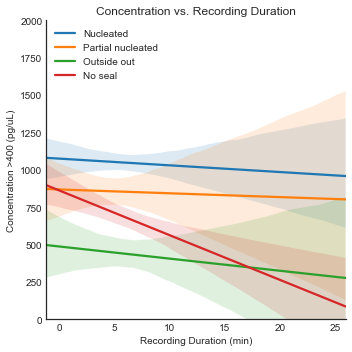

In [7]:
lm = sns.lmplot(x="recording duration", y="BA conc. >400 (pg/uL)", data=ps, hue="post patch class",
                scatter=False, legend=False)

axes = lm.axes #Set array of axes
axes[0,0].set_ylim(0,2000) #Sets axes as center coordinate & y limits

plt.title("Concentration vs. Recording Duration") #Create plot title
lm.set(xlabel="Recording Duration (min)",ylabel="Concentration >400 (pg/uL)") #Sets x and y axis labels 
lm.ax.legend(loc=2) #Creates manual legend with movable location

#loc is determined by quadrants 
#loc1 = quadrant 1
#loc2 = quadrant 2
#loc3 = quadrant 3
#loc4 = quadrant 4

#sns.despine() #Gets rid of the top and right spine on plot
plt.tight_layout() #Moves axes into place if out of frame
plt.savefig("conc_vs_rec_duration_seaborn.png",dpi=300) #Saves plot as .png